# Capstone Project:  Face Shape Classification - Part 1

This notebook consists of the following processes:
- Define the Problem Statement
- Gather Data
- Explore Data
- Prepare and save the first set of data for modelling

## Problem Statement

Based on [The Deloitte Consumer Review](https://www2.deloitte.com/content/dam/Deloitte/ch/Documents/consumer-business/ch-en-consumer-business-made-to-order-consumer-review.pdf), consumers are demanding more personalised experience, however there is still an unmet need in some categories.  Over 40% of adults aged 16-39 are interested in personalised beauty products and fashion accessories/jewelry, while trial remains low (only 10% and 14% respectively).  Among those who are interested in personalised products for these 2 categories, around 80% are willing to pay premium price (10% or more).

By being able to classify face shapes, brands will be able to offer more personalised solutions to better satisfy their consumers, while increasing margin from premium positioning.  Example of use cases are:
- Customised face mask [3D Printed Mask](https://www.red-dot.org/project/iope-tailored-solution-40454)
- Customised make-up tips based on face shape [vdo](https://www.youtube.com/watch?v=ZeJP_2IM-2Q)
- Recommendations for glasses or sunglasses
- Recommendations for accessories (i.e. earrings)

For this project, we will be using Deep Learning approach with Convolutional Neural Networks to classify 5 different female face shapes (Heart, Oblong, Oval, Round, Square).  The model that was highest accuracy score will be chosen.

## Import Libaries & Define initial functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import pickle
from torch.nn.functional import one_hot


%matplotlib inline

In [2]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)



In [3]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)


In [4]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)


In [5]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

## Gather Data - Images for Train & Test

Data Sources:

The [Face Shape Dataset](https://www.kaggle.com/niten19/face-shape-dataset) is a dataset from Kaggle by Niten Lama.

This dataset comprises a total of 5000 images of the female celebrities from all around the globe which are categorized according to their face-shape namely:
- Heart
- Oblong
- Oval
- Round
- Square

Each category consists of 1000 images (800 train : 200 test)




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_dir = '/content/drive/MyDrive/CV Project/FaceShape Dataset/training_set'
test_dir = '/content/drive/MyDrive/CV Project/FaceShape Dataset/testing_set'
# example_dir = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples'
categories = ['Heart','Oblong','Oval','Round','Square']

In [8]:
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}


In [14]:
def create_data_files(directory, array, resize=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                if resize != None:
                  img_array = cv2.resize(img_array, resize)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')

        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")



def create_data_files(directory, array, target_size=(224, 224)): # Define target_size
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                # Resize image to target_size
                img_array = cv2.resize(img_array, target_size)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')

        # Print progress every 400 images
        if i % 20 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")


In [15]:
# create training & testing data into a list
training_data = []
testing_data = []

create_data_files(train_dir, training_data) # Resize during data creation
create_data_files(test_dir, testing_data)   # Resize during data creation

# Convert to NumPy arrays (should work now with consistent shapes)
training_data = np.asarray(training_data, dtype=object)
testing_data = np.asarray(testing_data, dtype=object)

Images processed: 100 of 500
Images processed: 100 of 125


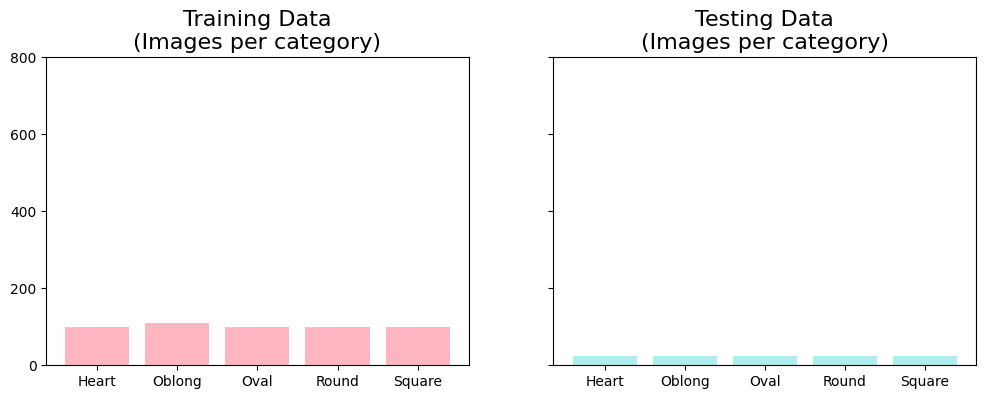

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

### Summarize Data and Display sample images

In [17]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (510, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [100 110 100 100 100]
Max Pixels: 231

--------------------------------------


Testing Dataset:

Shape: (125, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [25 25 25 25 25]
Max Pixels: 251

--------------------------------------



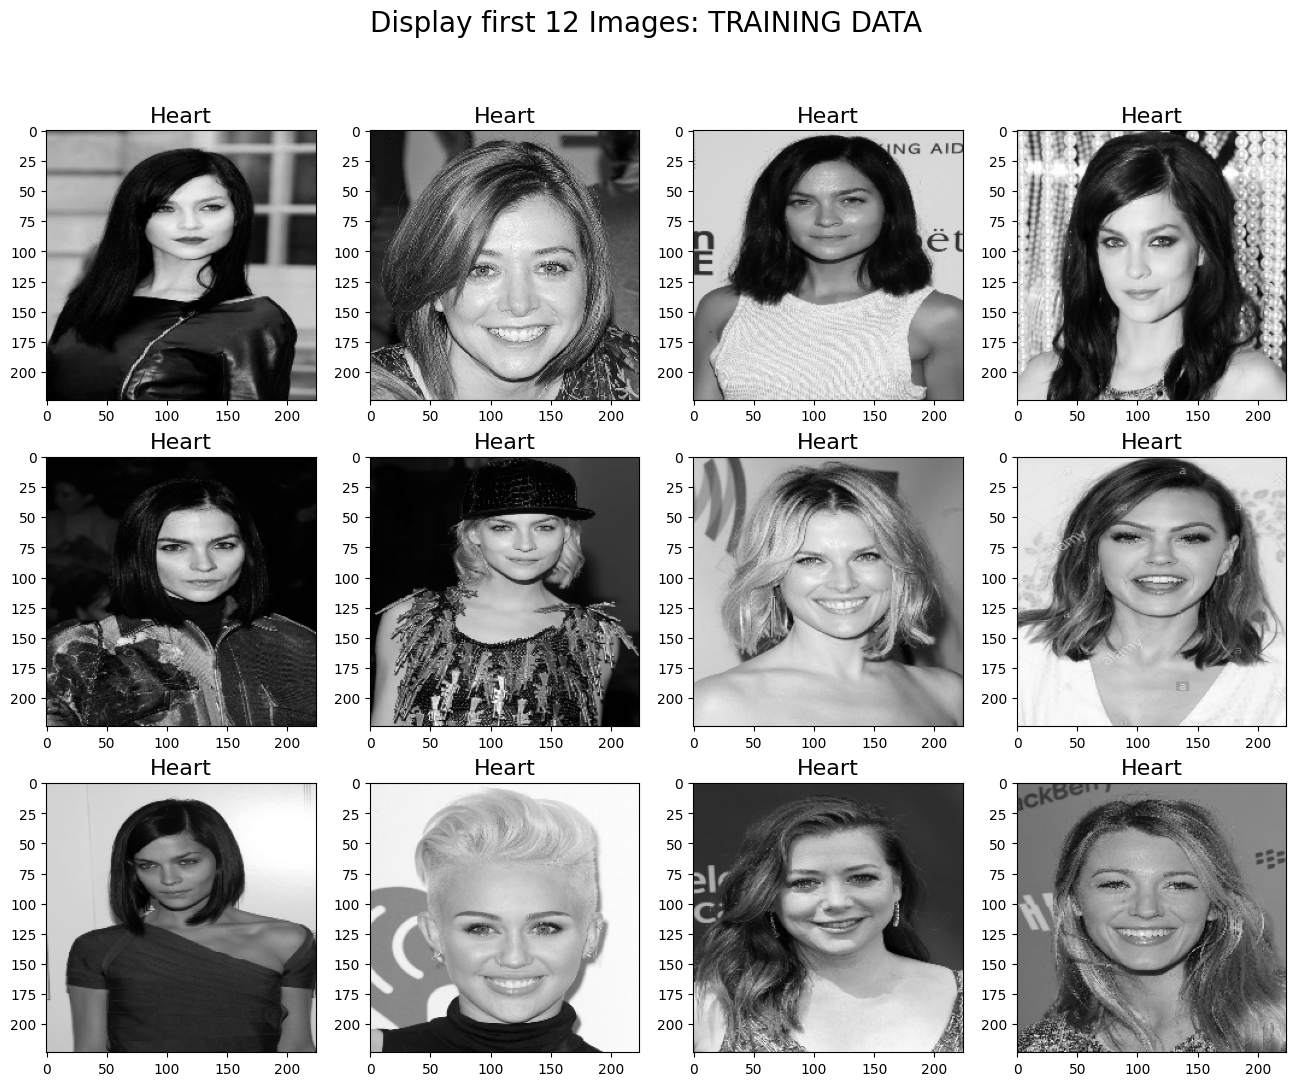

In [18]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

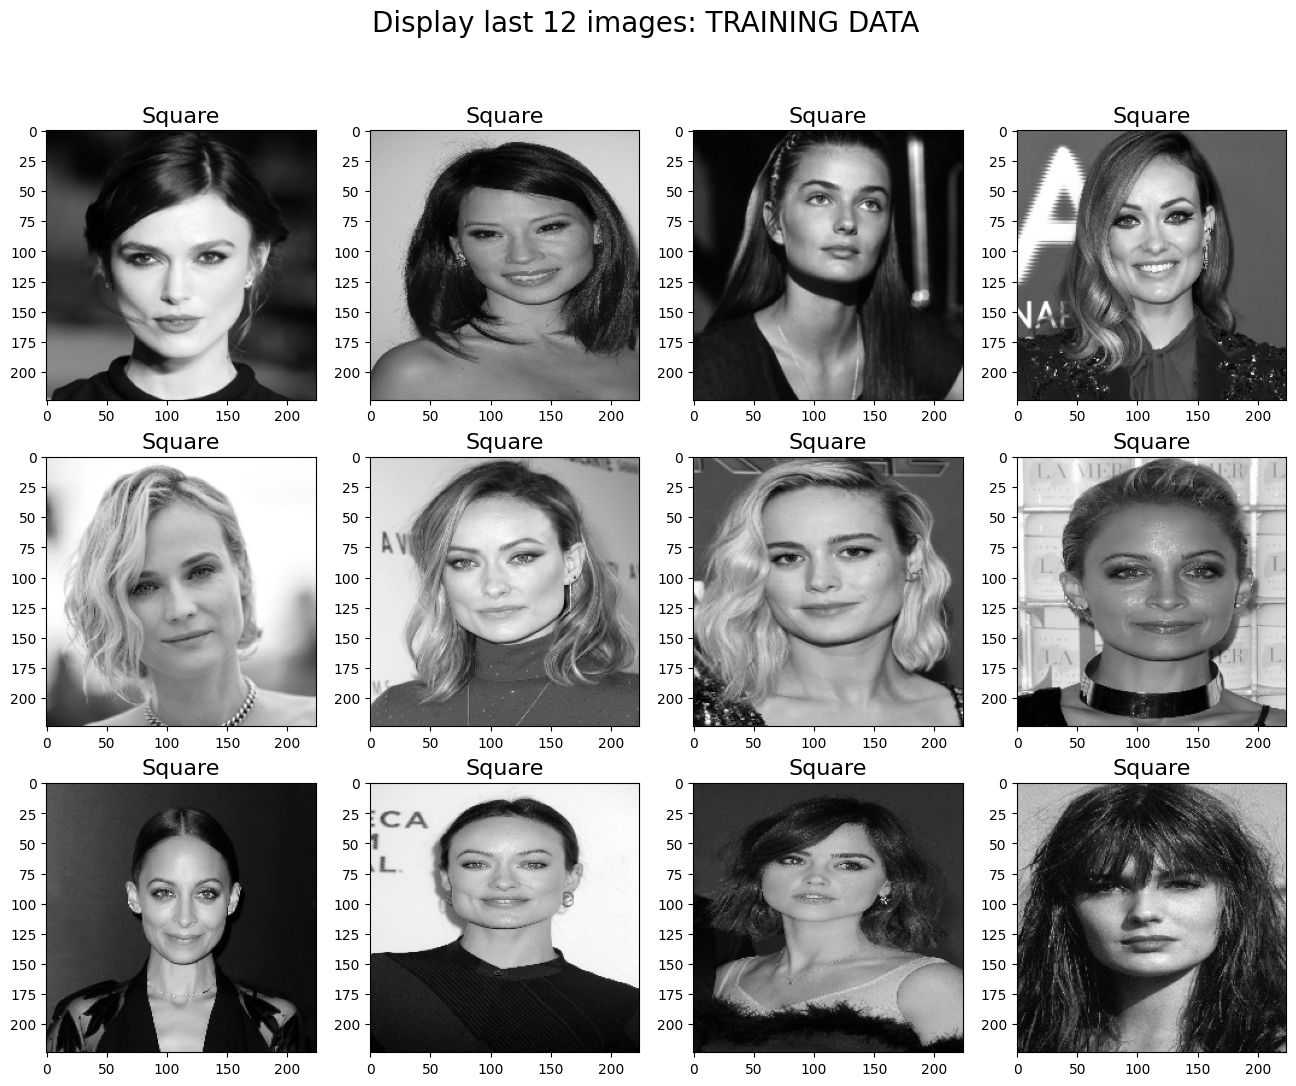

In [19]:
show_img(12, training_data[len(training_data)-12:], 'Display last 12 images: TRAINING DATA', ncols=4)

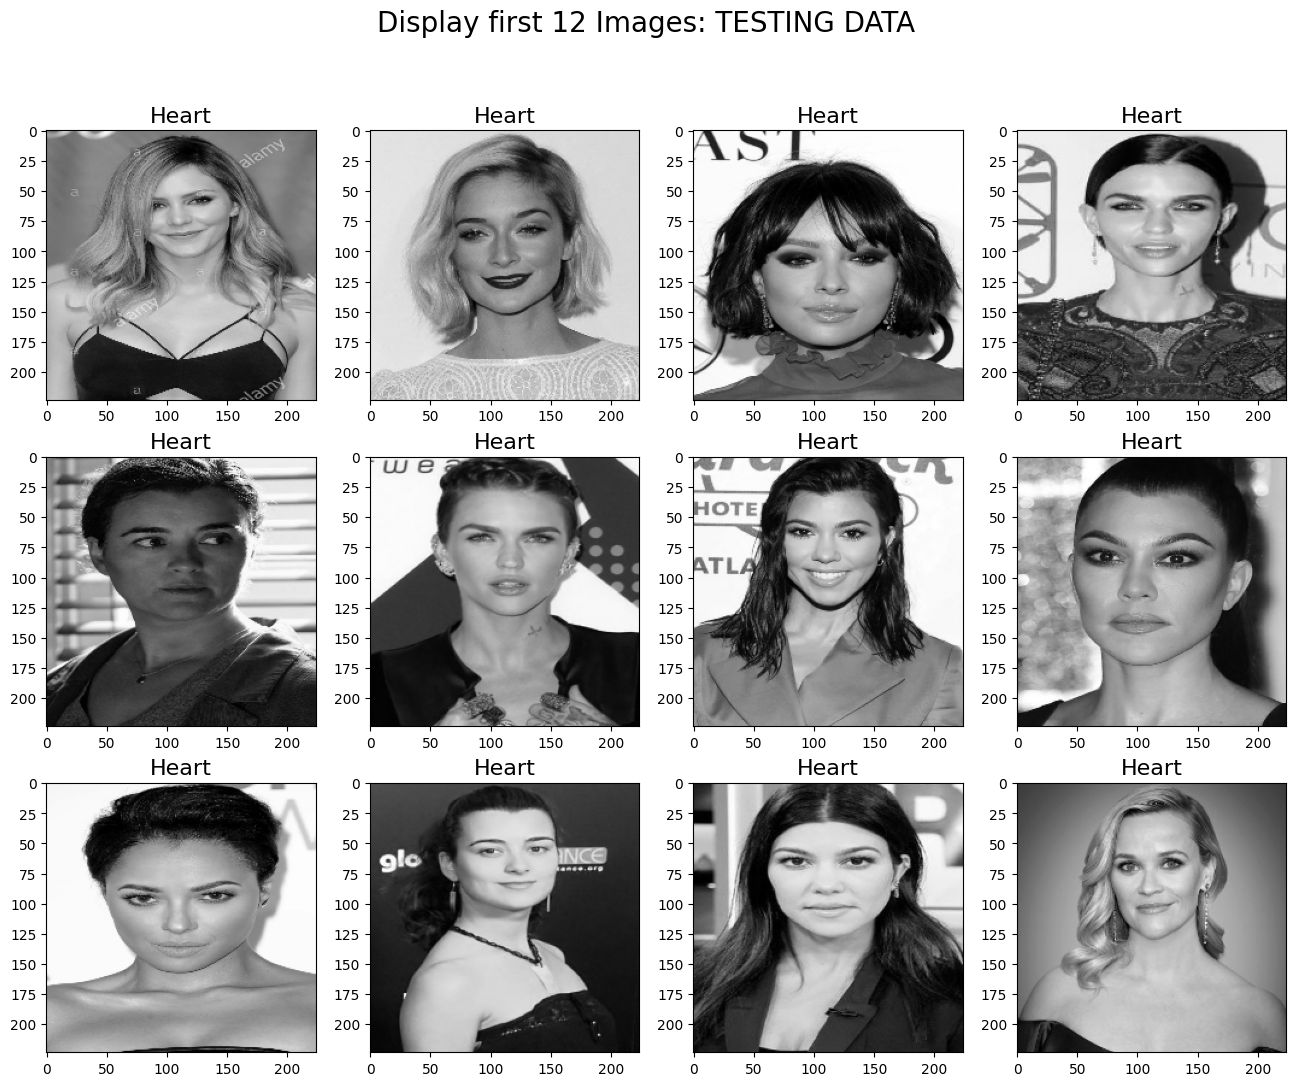

In [20]:
show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

## Exploratory Data Analysis

The images are in different sizes, so we need to resize all the images to be the same before we can run a model.  Common input sizes for CNN are as follows:  
   - VGG16 and Resnet50 : 224 x 224 x 3
   - Inception V3 : 299 x 299 x 3



### Let's analyse all the image sizes and their aspect ratios before we resize them

In [21]:
# Add all the image shapes into an array

shape = []

for image, label in training_data:
    try:
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        print("shape not found")

shape[:5]

[(224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]

In [22]:
# Create a data frame with the images and their shapes

train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map)
train.head(2)

img_array class   img_shape  \
0  [[87, 88, 88, 88, 88, 87, 85, 86, 88, 87, 87, ...     0  (224, 224)   
1  [[20, 22, 19, 19, 24, 22, 24, 21, 23, 21, 23, ...     0  (224, 224)   

  face_shape  
0      Heart  
1      Heart

#### When we sort the images by size, there seems to be variations from largest (9999, 6659) to smallest (159,112)

In [23]:
train.sort_values(by='img_shape', ascending=False)

img_array class   img_shape  \
0    [[87, 88, 88, 88, 88, 87, 85, 86, 88, 87, 87, ...     0  (224, 224)   
335  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...     3  (224, 224)   
348  [[229, 226, 229, 223, 226, 226, 224, 222, 224,...     3  (224, 224)   
347  [[239, 239, 240, 240, 240, 240, 239, 239, 238,...     3  (224, 224)   
346  [[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, ...     3  (224, 224)   
..                                                 ...   ...         ...   
165  [[58, 58, 55, 57, 56, 59, 57, 57, 58, 59, 60, ...     1  (224, 224)   
164  [[243, 243, 243, 242, 242, 242, 242, 242, 242,...     1  (224, 224)   
163  [[187, 187, 188, 190, 188, 187, 185, 187, 186,...     1  (224, 224)   
162  [[180, 160, 114, 77, 62, 65, 64, 62, 63, 62, 6...     1  (224, 224)   
509  [[142, 153, 148, 160, 147, 141, 143, 143, 142,...     4  (224, 224)   

    face_shape  
0        Heart  
335      Round  
348      Round  
347      Round  
346      Round  
..         ...  
165     Oblong  
164     Oblong  
163     Oblong  
162     Oblong  
509     Square  

[510 rows x 4 columns]

In [24]:
# Check the info, make sure there are no null values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   510 non-null    object
 1   class       510 non-null    object
 2   img_shape   510 non-null    object
 3   face_shape  510 non-null    object
dtypes: object(4)
memory usage: 16.1+ KB


#### Let's futher explore image sizes

In [25]:
# Create Height, Width, and Aspect Ratio for further analysis

train['height'] = train['img_shape'].map(lambda x : x[0])
train['width'] = train['img_shape'].map(lambda x : x[1])
train['aspect_ratio'] = train['width'] / train['height']
train

img_array class   img_shape  \
0    [[87, 88, 88, 88, 88, 87, 85, 86, 88, 87, 87, ...     0  (224, 224)   
1    [[20, 22, 19, 19, 24, 22, 24, 21, 23, 21, 23, ...     0  (224, 224)   
2    [[87, 199, 211, 211, 211, 211, 211, 211, 212, ...     0  (224, 224)   
3    [[209, 226, 243, 252, 230, 220, 201, 172, 149,...     0  (224, 224)   
4    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...     0  (224, 224)   
..                                                 ...   ...         ...   
505  [[255, 255, 255, 252, 231, 211, 212, 216, 218,...     4  (224, 224)   
506  [[91, 93, 83, 82, 85, 85, 83, 88, 82, 81, 78, ...     4  (224, 224)   
507  [[227, 229, 228, 228, 227, 228, 228, 229, 230,...     4  (224, 224)   
508  [[37, 41, 46, 45, 44, 38, 37, 35, 35, 44, 46, ...     4  (224, 224)   
509  [[142, 153, 148, 160, 147, 141, 143, 143, 142,...     4  (224, 224)   

    face_shape  height  width  aspect_ratio  
0        Heart     224    224           1.0  
1        Heart     224    224           1.0  
2        Heart     224    224           1.0  
3        Heart     224    224           1.0  
4        Heart     224    224           1.0  
..         ...     ...    ...           ...  
505     Square     224    224           1.0  
506     Square     224    224           1.0  
507     Square     224    224           1.0  
508     Square     224    224           1.0  
509     Square     224    224           1.0  

[510 rows x 7 columns]

In [26]:
train.describe()

height  width  aspect_ratio
count   510.0  510.0         510.0
mean    224.0  224.0           1.0
std       0.0    0.0           0.0
min     224.0  224.0           1.0
25%     224.0  224.0           1.0
50%     224.0  224.0           1.0
75%     224.0  224.0           1.0
max     224.0  224.0           1.0

In [27]:
# Defines a function to plot histograms showing comparative distributions of variables in a dataframe

def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels,
                       figsize=(10,8), bins = 15,ncols=2,nrows=0, sharex=True, sharey=True, figtitle=None):
    """plot histograms with subplots in matplotlib"""
    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols,
                           sharex=sharex, sharey=sharey) # You'll want to specify your figsize
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=bins, color='mediumaquamarine') # feel free to add more settings
        ax[i].set_title(list_of_titles[i])# Set titles, labels, etc here for each subplot
        if (i >= (ncols*nrows)/2):
            ax[i].set_xlabel(list_of_xlabels[i])  # only show x labels on bottom ax plots
        if (sharey==True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # only show y labels on left ax plots
    plt.tight_layout()
    # plt.savefig(f'../plots/{figtitle}.png');

#### Most of the images are portrait mode with few squares and landscape.  We need to resize them into squares for modelling

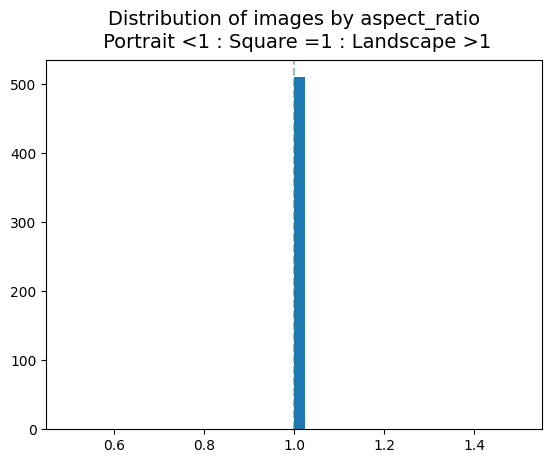

In [31]:
plt.hist(train['aspect_ratio'],bins=40)
plt.title('Distribution of images by aspect_ratio\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

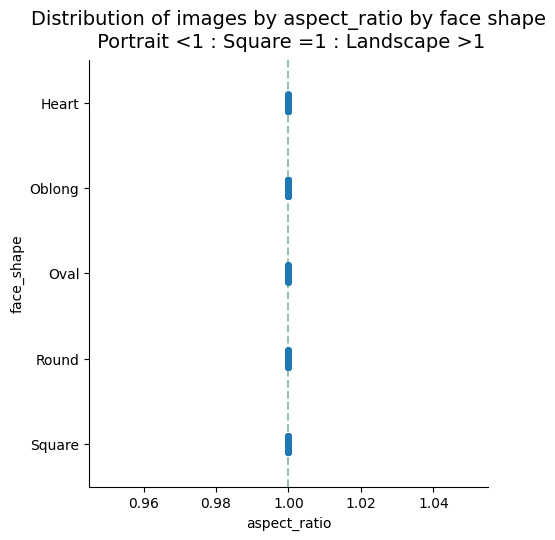

In [32]:
fig.suptitle('Image by Aspect Ratio (square=1)')
sns.catplot(data=train, x='aspect_ratio',y='face_shape')
plt.title('Distribution of images by aspect_ratio by face shape\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

### Let's try to see if we resize everything to 224 x 224
The images look a bit distorted, but let's try an initial CNN to see how the model performs.

## Prepare Data and Export files for modelling

In [ ]:
def train_test_prep(training_data_array, testing_data_array):
    # shuffle the images to mix all the classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into arrays
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # Convert to numpy arrays and normalize
    X_train = np.array(X_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)

    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Convert labels to one-hot encoded tensors
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_train = one_hot(y_train, num_classes=5).float()

    y_test = torch.tensor(y_test, dtype=torch.long)
    y_test = one_hot(y_test, num_classes=5).float()

    # Convert features to tensors and add channel dimension
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)

    # Add channel dimension if images are grayscale (1 channel)
    if X_train.ndim == 3:
        X_train = X_train.unsqueeze(1)  # Shape becomes [N, 1, H, W]
        X_test = X_test.unsqueeze(1)

    return X_train, X_test, y_train, y_test

In [49]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/'
    data_path= '/content/drive/MyDrive/CV Project/Pickle Files'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [37]:
# create new training & testing data with resizing

training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

Images processed: 100 of 500
Images processed: 100 of 125


In [42]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape torch.Size([510, 1, 224, 224])
X_test.shape torch.Size([125, 1, 224, 224])
y_train.shape torch.Size([510, 5])
y_test.shape torch.Size([125, 5])


In [43]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (510, 224, 224, 1)
X_test.shape (125, 224, 224, 1)
y_train.shape torch.Size([510, 5])
y_test.shape torch.Size([125, 5])


In [50]:
# need to comment out this part after running this code & generating pickle files
# otherwise it will append to existing file everytime we run it

pickle_out(X_train, X_test, y_train, y_test, 'r224')

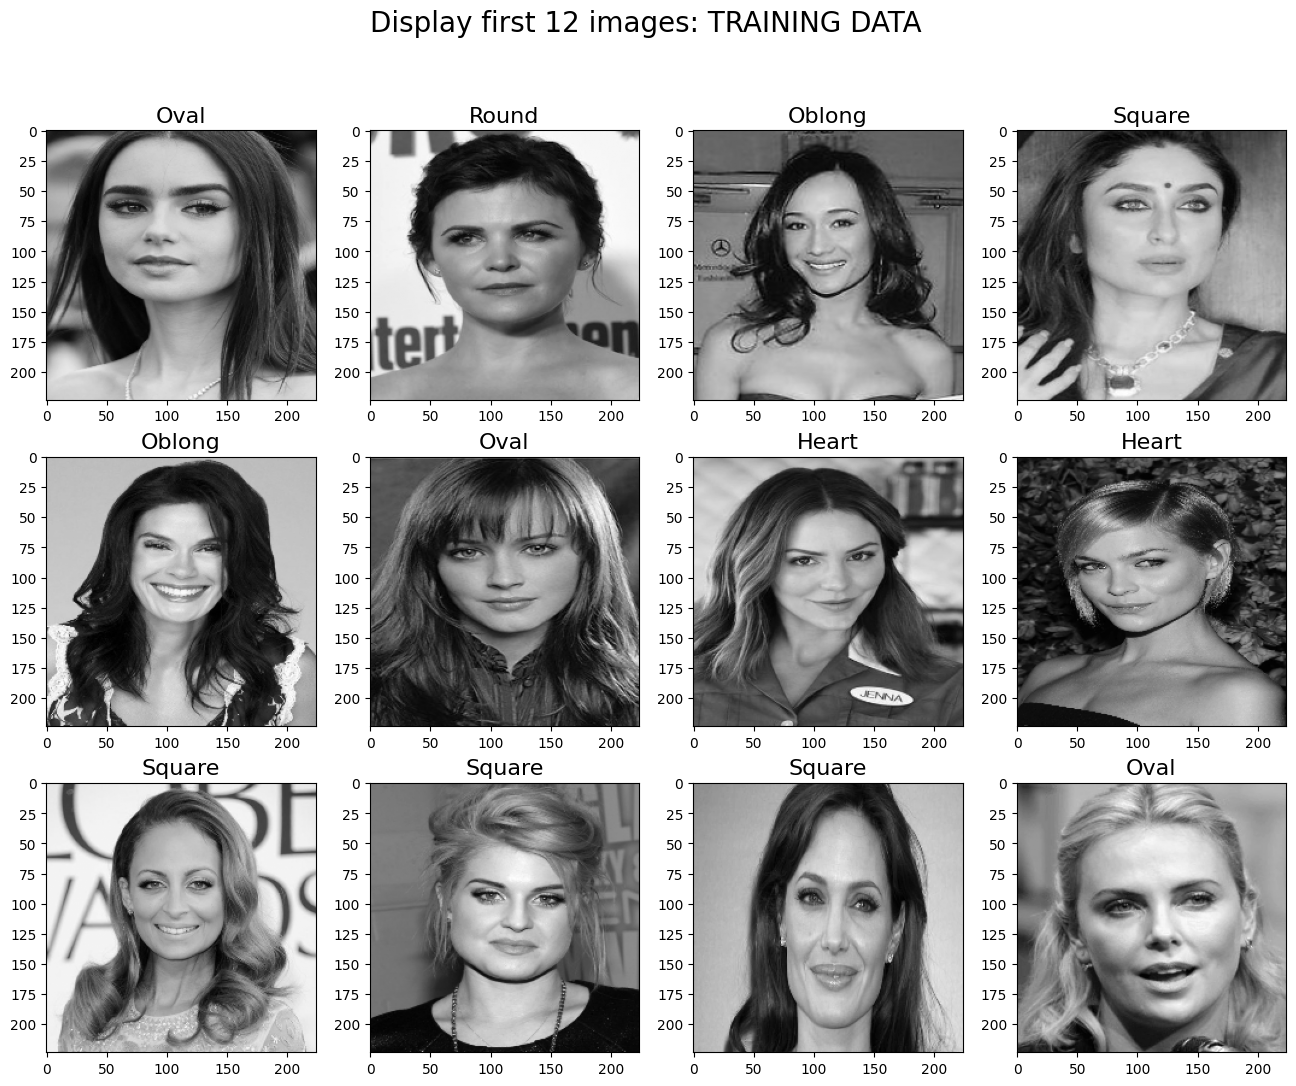

In [44]:
show_img(12, training_data[:12], 'Display first 12 images: TRAINING DATA', ncols=4)

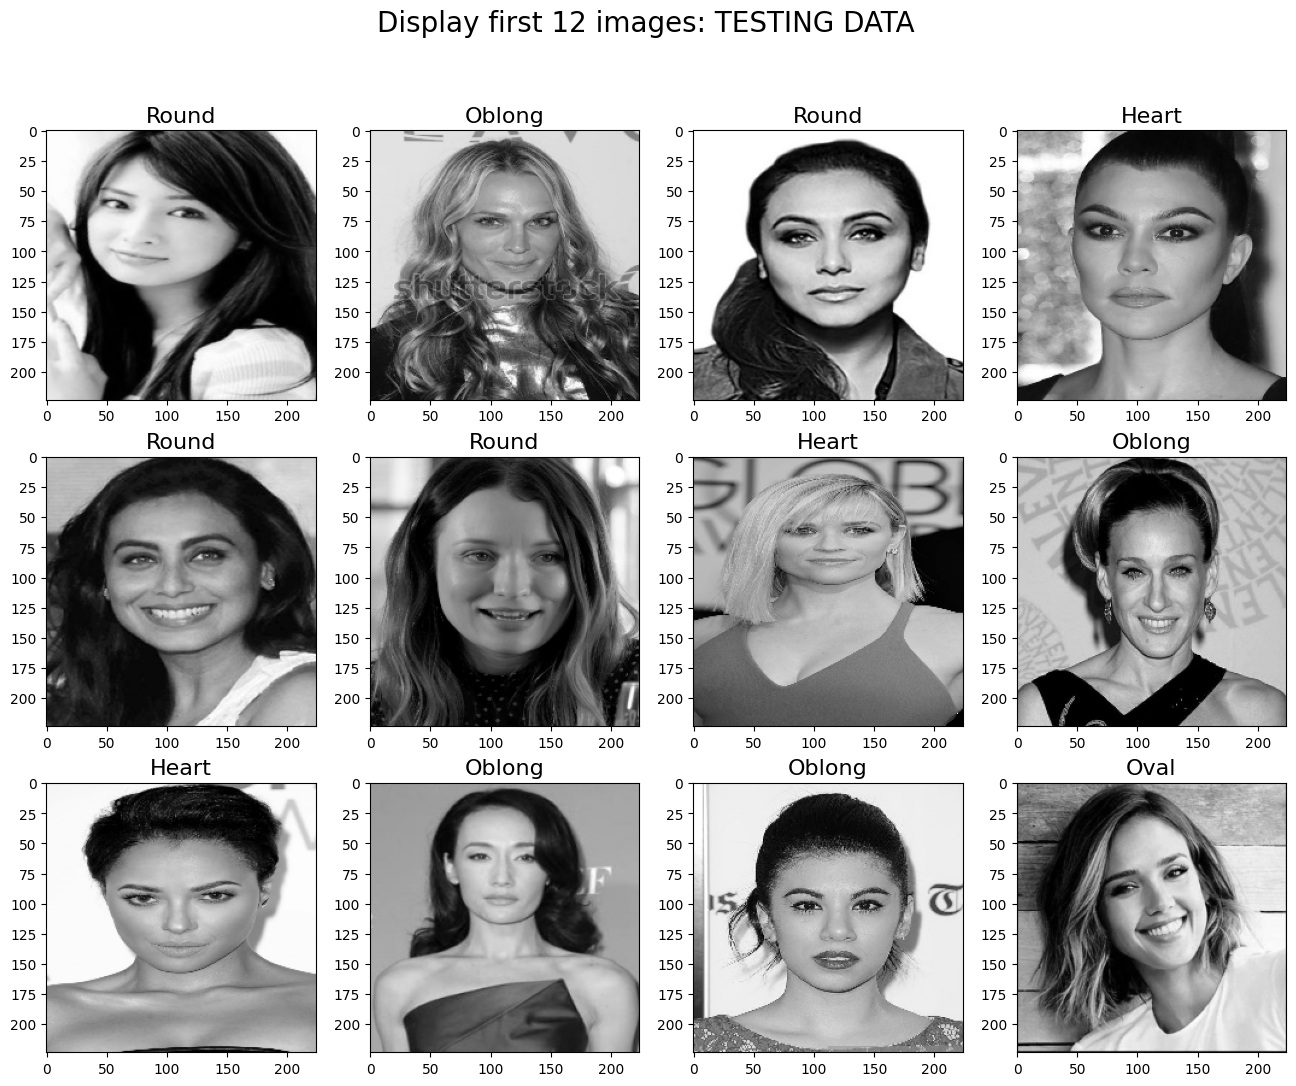

In [45]:
show_img(12, testing_data[:12], 'Display first 12 images: TESTING DATA', ncols=4)